p# Importing libraries

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import networkx as nx


# SEED = 19 + 14 ## sum of length of our full names or just use 42
SEED = 42

## Defining helper functions

In [2]:
def plot_poisson_dag():
    G = nx.DiGraph()

    labels = {
        'X': 'X (Predictors)',
        'nkill': 'nkill (Observed Counts)',
        'alpha': 'alpha',
        'beta': 'beta',
        'eta': 'eta = alpha + X * beta',
        'nkill_dist': 'Poisson_log(nkill | eta)',
        'nkill_pred': 'nkill_pred'
    }

    for node in labels:
        G.add_node(node)

    G.add_edges_from([
        ('X', 'eta'),
        ('beta', 'eta'),
        ('alpha', 'eta'),
        ('eta', 'nkill_dist'),
        ('nkill_dist', 'nkill'),
        ('eta', 'nkill_pred')
    ])

    pos = {
        'X': (0, 2),
        'alpha': (0, 0),
        'beta': (2, 0),
        'eta': (1, 1),
        'nkill_dist': (3, 1),
        'nkill': (4, 1),
        'nkill_pred': (3, -1),
    }

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color='skyblue', arrowsize=20)

    ax = plt.gca()
    for node, (x, y) in pos.items():
        ax.text(x, y + 0.15, labels[node],
                horizontalalignment='center',
                fontsize=9, fontweight='bold', color='black') # or white

    plt.title('Poisson Regression Model DAG')
    plt.axis('off')
    plt.show()


def plot_negative_binomial_dag():
    G = nx.DiGraph()

    labels = {
        'X': 'X (Predictors)',
        'nkill': 'nkill (Observed Counts)',
        'alpha': 'alpha',
        'beta': 'beta',
        'phi': 'phi',
        'eta': 'eta = alpha + X * beta',
        'nkill_dist': 'NegBinomial_2_log(nkill | eta, phi)',
        'nkill_pred': 'nkill_pred'
    }
    for node in labels:
        G.add_node(node)

    G.add_edges_from([
        ('X', 'eta'),
        ('beta', 'eta'),
        ('alpha', 'eta'),
        ('phi', 'nkill_dist'),
        ('eta', 'nkill_dist'),
        ('nkill_dist', 'nkill'),
        ('phi', 'nkill_pred'),
        ('eta', 'nkill_pred')
    ])

    pos = {
        'X': (0, 2),
        'alpha': (0, 0),
        'beta': (2, 0),
        'eta': (1, 1),
        'phi': (2, -1),
        'nkill_dist': (3, 1),
        'nkill': (4, 1),
        'nkill_pred': (3, -1),
    }

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color='skyblue', arrowsize=20)

    ax = plt.gca()
    for node, (x, y) in pos.items():
        ax.text(x, y + 0.15, labels[node],
                horizontalalignment='center',
                fontsize=9, fontweight='bold', color='black') # or white

    plt.title('Negative Binomial Regression Model DAG')
    plt.axis('off')
    plt.show()

## Load & preparing data

In [3]:
# df = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='latin-1')
df = pd.read_csv("Project/Data-Analitics-Project/globalterrorismdb_0718dist.csv", encoding='latin-1')
df.head()

/tmp/ipykernel_286/622743915.py:2: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Project/Data-Analitics-Project/globalterrorismdb_0718dist.csv", encoding='latin-1')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [4]:
selected_columns = ['nkill', 'attacktype1_txt', 'weaptype1_txt', 'targtype1_txt', 'country_txt', 'nperps']
df = df[selected_columns].dropna()
df = df.sample(n=1000, random_state=SEED)
df.to_csv('data.csv')

## Counting mean and standard deviation

In [5]:
alpha_mean = np.log1p(df['nkill']).mean()
alpha_std = np.log1p(df['nkill']).std()

print(alpha_mean, alpha_std)

0.6460148321311442 0.8190179737627902


In [6]:
np.mean(df['nperps']), np.std(df['nperps'])

(np.float64(-70.522), np.float64(56.919851686384426))

In [7]:
print(df.describe())

             nkill       nperps
count  1000.000000  1000.000000
mean      2.164000   -70.522000
std       5.998257    56.948333
min       0.000000   -99.000000
25%       0.000000   -99.000000
50%       1.000000   -99.000000
75%       2.000000   -99.000000
max      83.000000   600.000000


In [8]:
categorical_cols = ['attacktype1_txt', 'weaptype1_txt', 'targtype1_txt', 'country_txt']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Standardisation of variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(['nkill'], axis=1))

In [9]:
stan_data = {
    'N': df_encoded.shape[0],
    'K': X_scaled.shape[1],
    'X': X_scaled,
    'nkill': df_encoded['nkill'].astype(int).values
}

## Building & fitting first model

In [10]:
# model_ppc = CmdStanModel(stan_file='code_1.stan')
model_ppc = CmdStanModel(stan_file='Project/Data-Analitics-Project/code_1.stan')

fit = model_ppc.sample(
    data=stan_data,
    chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=SEED
)

print(fit.summary())

10:13:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:13:10 - cmdstanpy - INFO - CmdStan done processing.



                        Mean      MCSE    StdDev       MAD          5%  \
lp__              679.309000  0.211173  8.041730  8.051260  665.708000   
alpha              -0.443463  0.002037  0.082164  0.082561   -0.580021   
beta[1]             0.224025  0.000211  0.013235  0.013119    0.201512   
beta[2]            -0.194469  0.000699  0.040175  0.039894   -0.259256   
beta[3]            -0.041446  0.001166  0.071008  0.071420   -0.157034   
...                      ...       ...       ...       ...         ...   
nkill_pred[996]     1.519250  0.021720  1.269660  1.482600    0.000000   
nkill_pred[997]     2.593500  0.026651  1.611800  1.482600    0.000000   
nkill_pred[998]     0.194750  0.007010  0.452077  0.000000    0.000000   
nkill_pred[999]     0.121500  0.005375  0.347517  0.000000    0.000000   
nkill_pred[1000]    6.087750  0.039727  2.482260  2.965200    2.000000   

                         50%         95%  ESS_bulk  ESS_tail     R_hat  
lp__              679.651000  691.748

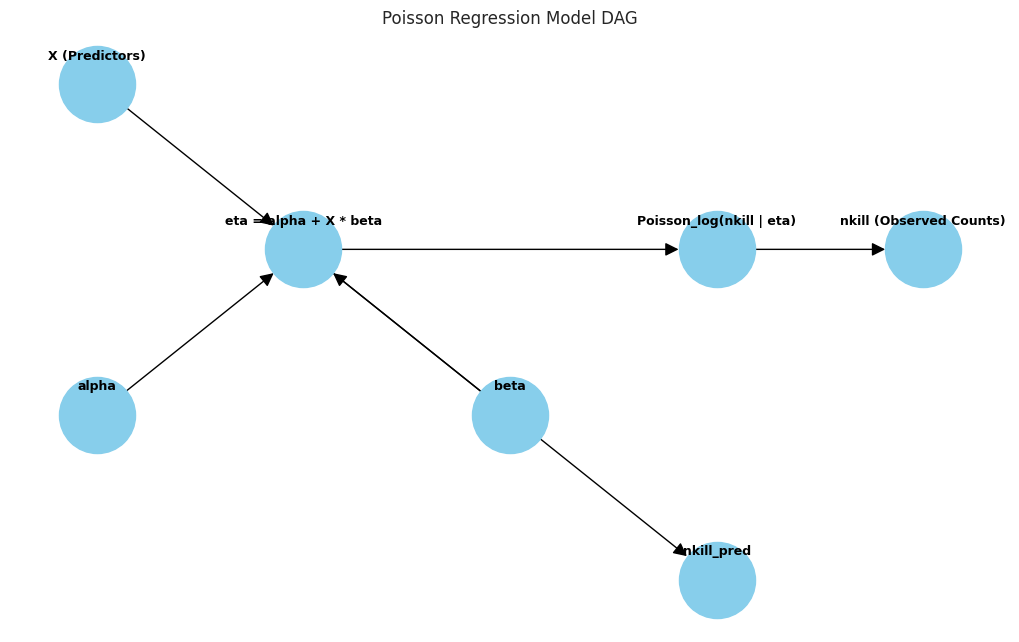

In [11]:
plot_poisson_dag()

## Presenting results

In [12]:
y_pred_poisson = fit.stan_variable('nkill_pred')
y_true_poisson = df_encoded['nkill'].values
y_pred_mean_poisson = np.mean(y_pred_poisson, axis=0)

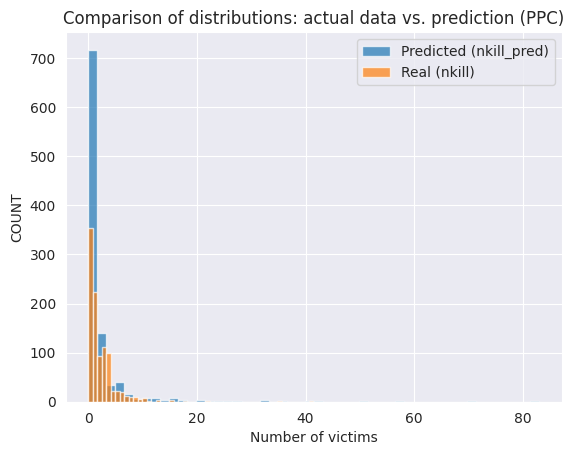

In [13]:
plt.hist(y_true_poisson, bins=50, alpha=0.7, label='Predicted (nkill_pred)')
plt.hist(y_pred_mean_poisson, bins=50, alpha=0.7, label='Real (nkill)')
plt.xlabel('Number of victims')
plt.ylabel('COUNT')
plt.legend()
plt.title('Comparison of distributions: actual data vs. prediction (PPC)')
plt.show()


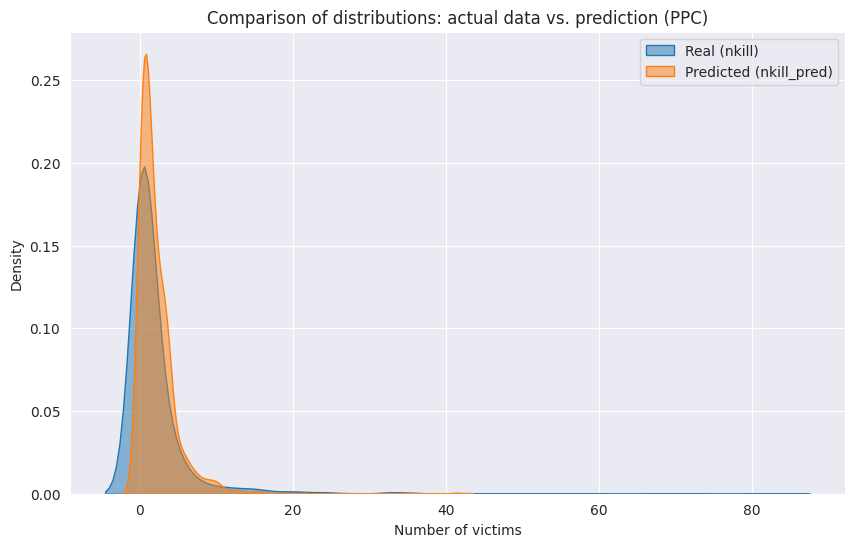

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.kdeplot(y_true_poisson, label='Real (nkill)', fill=True, alpha=0.5)
sns.kdeplot(y_pred_mean_poisson, label='Predicted (nkill_pred)', fill=True, alpha=0.5)
plt.xlabel('Number of victims')
plt.ylabel('Density')
plt.legend()
plt.title('Comparison of distributions: actual data vs. prediction (PPC)')
plt.show()


In [15]:
for n in range(0, 500000):
    true_count = np.sum(y_true_poisson == n)
    pred_count = np.sum(np.round(y_pred_mean_poisson) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")


Number of victims = 0: Real = 488, Predicted = 259
Number of victims = 1: Real = 229, Predicted = 299
Number of victims = 2: Real = 89, Predicted = 114
Number of victims = 3: Real = 50, Predicted = 115
Number of victims = 4: Real = 35, Predicted = 108
Number of victims = 5: Real = 26, Predicted = 29
Number of victims = 6: Real = 15, Predicted = 20
Number of victims = 7: Real = 7, Predicted = 14
Number of victims = 8: Real = 8, Predicted = 11
Number of victims = 9: Real = 5, Predicted = 7
Number of victims = 10: Real = 4, Predicted = 11
Number of victims = 11: Real = 4, Predicted = 2
Number of victims = 12: Real = 5, Predicted = 1
Number of victims = 13: Real = 2, Predicted = 3
Number of victims = 14: Real = 3, Predicted = 0
Number of victims = 15: Real = 5, Predicted = 3
Number of victims = 16: Real = 2, Predicted = 0
Number of victims = 17: Real = 1, Predicted = 0
Number of victims = 18: Real = 2, Predicted = 1
Number of victims = 20: Real = 3, Predicted = 0
Number of victims = 21: Re

## Building & fitting second model

In [16]:
# model_ppc = CmdStanModel(stan_file='code_2.stan')
model_ppc = CmdStanModel(stan_file='Project/Data-Analitics-Project/code_2.stan')

fit = model_ppc.sample(
    data=stan_data,
    chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=SEED
)

print(fit.summary())

10:13:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:13:31 - cmdstanpy - INFO - CmdStan done processing.
10:13:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
	Exception: neg_binomia


                         Mean      MCSE    StdDev       MAD           5%  \
lp__             -1629.750000  0.225697  8.588900  8.621320 -1644.300000   
alpha               -0.370535  0.002091  0.092863  0.091999    -0.527695   
beta[1]              0.410156  0.001099  0.069165  0.067812     0.297837   
beta[2]             -0.127714  0.001205  0.075884  0.077152    -0.250743   
beta[3]              0.167807  0.002488  0.164897  0.162077    -0.109871   
...                       ...       ...       ...       ...          ...   
nkill_pred[996]      3.599750  0.088796  5.571110  2.965200     0.000000   
nkill_pred[997]      2.837750  0.066002  4.097640  1.482600     0.000000   
nkill_pred[998]      0.223250       NaN  0.659938  0.000000     0.000000   
nkill_pred[999]      0.115500  0.006330  0.401497  0.000000     0.000000   
nkill_pred[1000]     6.519500  0.143619  9.078750  4.447800     0.000000   

                          50%          95%  ESS_bulk  ESS_tail     R_hat  
lp__       

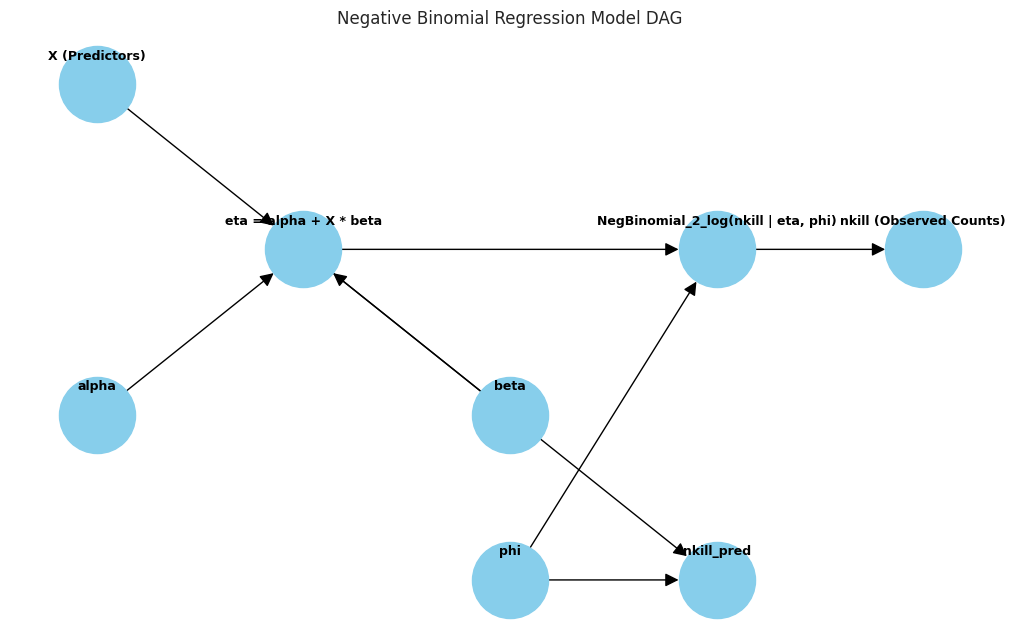

In [17]:
plot_negative_binomial_dag()

## Presenting results for second model

In [18]:
y_pred_binomial = fit.stan_variable('nkill_pred')
y_true_binomial = df_encoded['nkill'].values
y_pred_mean_binomial = np.mean(y_pred_binomial, axis=0)

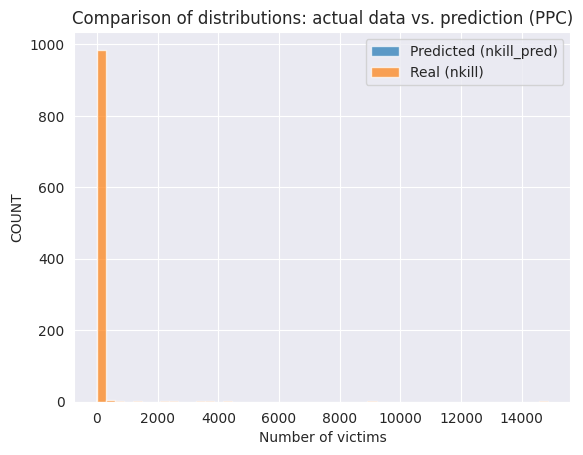

In [19]:
plt.hist(y_true_binomial, bins=50, alpha=0.7, label='Predicted (nkill_pred)')
plt.hist(y_pred_mean_binomial, bins=50, alpha=0.7, label='Real (nkill)')
plt.xlabel('Number of victims')
plt.ylabel('COUNT')
plt.legend()
plt.title('Comparison of distributions: actual data vs. prediction (PPC)')
plt.show()

In [20]:
for n in range(0, 500):
    true_count = np.sum(y_true_binomial == n)
    pred_count = np.sum(np.round(y_pred_mean_binomial) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")


Number of victims = 0: Real = 488, Predicted = 221
Number of victims = 1: Real = 229, Predicted = 274
Number of victims = 2: Real = 89, Predicted = 152
Number of victims = 3: Real = 50, Predicted = 162
Number of victims = 4: Real = 35, Predicted = 30
Number of victims = 5: Real = 26, Predicted = 34
Number of victims = 6: Real = 15, Predicted = 20
Number of victims = 7: Real = 7, Predicted = 20
Number of victims = 8: Real = 8, Predicted = 14
Number of victims = 9: Real = 5, Predicted = 15
Number of victims = 10: Real = 4, Predicted = 5
Number of victims = 11: Real = 4, Predicted = 10
Number of victims = 12: Real = 5, Predicted = 1
Number of victims = 13: Real = 2, Predicted = 3
Number of victims = 14: Real = 3, Predicted = 1
Number of victims = 15: Real = 5, Predicted = 1
Number of victims = 16: Real = 2, Predicted = 2
Number of victims = 17: Real = 1, Predicted = 1
Number of victims = 18: Real = 2, Predicted = 2
Number of victims = 19: Real = 0, Predicted = 2
Number of victims = 20: Re

## Comparing first and second model with actual data

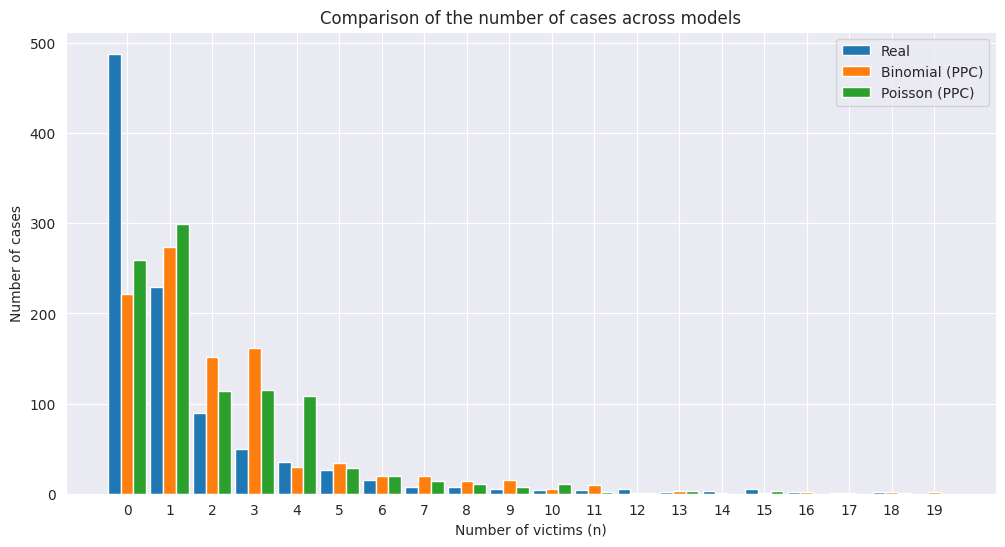

In [21]:
import numpy as np
import matplotlib.pyplot as plt

n_values = np.arange(0, 20)


true_counts = []
binomial_counts = []
poisson_counts = []

for n in n_values:
    true_count = np.sum(y_true_binomial == n)
    binomial_count = np.sum(np.round(y_pred_mean_binomial) == n)
    poisson_count = np.sum(np.round(y_pred_mean_poisson) == n)
    
    true_counts.append(true_count)
    binomial_counts.append(binomial_count)
    poisson_counts.append(poisson_count)


bar_width = 0.3
index = np.arange(len(n_values))

plt.figure(figsize=(12,6))
plt.bar(index - bar_width, true_counts, bar_width, label='Real')
plt.bar(index, binomial_counts, bar_width, label='Binomial (PPC)')
plt.bar(index + bar_width, poisson_counts, bar_width, label='Poisson (PPC)')

plt.xlabel('Number of victims (n)')
plt.ylabel('Number of cases')
plt.xticks(index, n_values)
plt.legend()
plt.title('Comparison of the number of cases across models')
plt.show()


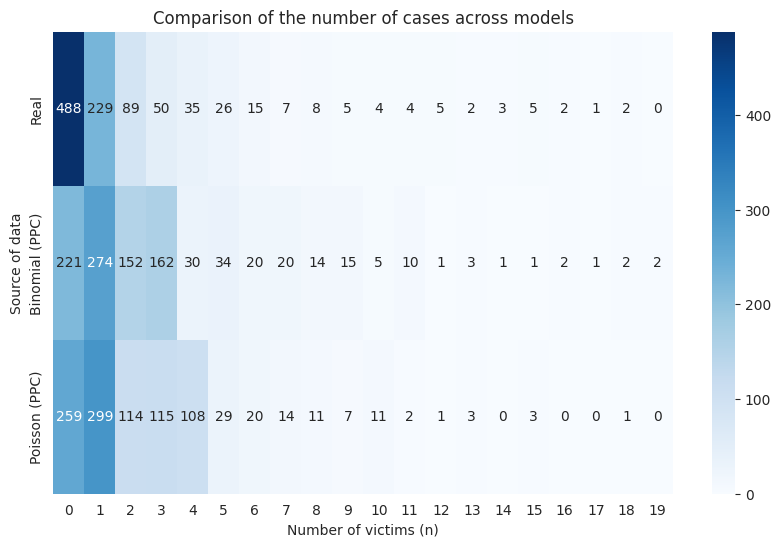

In [22]:
import pandas as pd
import seaborn as sns

df_heatmap = pd.DataFrame({
    'n': n_values,
    'Real': true_counts,
    'Binomial (PPC)': binomial_counts,
    'Poisson (PPC)': poisson_counts
}).set_index('n')

plt.figure(figsize=(10,6))
sns.heatmap(df_heatmap.T, annot=True, fmt='d', cmap='Blues')
plt.title('Comparison of the number of cases across models')
plt.xlabel('Number of victims (n)')
plt.ylabel('Source of data')
plt.show()